----- Chang Xiu ------

In [7]:
###########Function#####################
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy import spatial
from sklearn.neighbors import KDTree

def oversample(df, numericColumn, itemColumns):
  """
  Purpose: To make the item class balance
  Input: a data frame, numericColumn indicate which column is numeric, itemColumns indicating which column is the item class
  Output: data frame with balance class
  """
  
  nonItemColumns = [i for i in list(df.columns) if i not in itemColumns]
  output = pd.DataFrame()
  categoricalColumn = set(df.columns) - set(numericColumn) - set(itemColumns)
  
  for i in range(0, len(itemColumns)):
    temp = pd.concat([df[nonItemColumns], df[itemColumns[i]]], axis = 1).dropna()
    smote = SMOTENC(categorical_features = [temp[nonItemColumns].columns.get_loc(i) for i in categoricalColumn])
    x_smote, y_smote = smote.fit_resample(temp[nonItemColumns], temp[itemColumns[i]])
    output = pd.concat([output, pd.concat([x_smote, y_smote], axis = 1)], axis = 0)
  return output
  
  

In [8]:
def MBRS_fit(df, numericColumn, itemColumns):
  """
  Purpose:Train the model-based recommendation system
  Input: a data frame, numericColumn indicate which column is numeric, itemColumns indicating which column is the item to be recommended
  Output: a set of model with a scaler to normalize data and a classifier for each item that predict whether a user will buy the item
  """
  
  model = {}
  df = df.copy()
  nonItemColumns = [i for i in list(df.columns) if i not in itemColumns]
  
  #Normalization
  model['scaler'] = preprocessing.StandardScaler().fit(df[numericColumn])
  df[numericColumn] = model['scaler'].transform(df[numericColumn])

  #Training
  for i in range(0, len(itemColumns)):
    
    #subset data frame by removing item column not in question
    item = itemColumns[i]
    temp_itemColumns = itemColumns.copy()
    temp_itemColumns.remove(item)
    temp_df = df.drop(temp_itemColumns, axis = 1).dropna()
    
    #Train the model
    clf = LogisticRegression(max_iter = 10000)
    clf = clf.fit(temp_df[nonItemColumns], temp_df[item])
    
    #Store the model
    model[item] = clf
  
  return model

In [9]:
def MBRS_predict(df, numericColumn, itemColumns, model):
  """
  Purpose: Predict and recommend using the model given
  Input: a data frame, numericColumn indicate which column is numeric, itemColumns indicating which column is the item to be recommended, a set of model
  Output: original input data frame with the additional column of predicted class and probability for buying each item and recommendation for each user
  """
  
  nonItemColumns = [i for i in list(df.columns) if i not in itemColumns]
  df = df.dropna(subset = nonItemColumns).copy()
  prediction_df = pd.DataFrame(columns = [i + "_predclass" for i in itemColumns] + [i + "_prob" for i in itemColumns] + ["Recommendation"], index = df.index)
  
  #Normalization
  df[numericColumn] = model['scaler'].transform(df[numericColumn])

  #Predict
  for j in range(0, len(itemColumns)):
    item = itemColumns[j]
    prediction_df[item + "_prob"] = pd.DataFrame(model[item].predict_proba(df[nonItemColumns]), index = df.index)[1]
    prediction_df[item + "_predclass"] = pd.DataFrame(model[item].predict(df[nonItemColumns]), index = df.index)[0]
    
  #Recommend  
  prediction_df["Recommendation"] = prediction_df[[i + "_prob" for i in itemColumns]].idxmax(axis = 1) # Select the item column with max probability
  prediction_df["Recommendation"] = prediction_df["Recommendation"].str.replace("_prob", "")
  
  return pd.concat([df, prediction_df], axis = 1)

In [10]:
def NBRS_fit(df, k, numericColumn, itemColumns):
    model = {}
    df = df.copy()
    nonItemColumns = [i for i in list(df.columns) if i not in itemColumns]
    
    #Normalization
    model['scaler'] = preprocessing.StandardScaler().fit(df[numericColumn])
    df[numericColumn] = model['scaler'].transform(df[numericColumn])
    
    #Train the model
    model['Neighbour'] = df
    model['k'] = k
    for item in itemColumns:
        model[item + '_tree'] = KDTree(df[df[item].notna()][nonItemColumns], metric = "euclidean")
    return model
    

In [11]:
def NBRS_predict(df, numericColumn, itemColumns, model):
    
    nonItemColumns = [i for i in list(df.columns) if i not in itemColumns]
    df = df.dropna(subset = nonItemColumns).copy()
    prediction_df = pd.DataFrame(columns = [i + "_predclass" for i in itemColumns] + [i + "_rating" for i in itemColumns] + ["Recommendation"], index = df.index)
    prediction_df = prediction_df.astype("float64")
    df = pd.concat([df, prediction_df], axis = 1)
    df = df.reset_index()
    
    #Fix missing dummies column
    missing_cols = set(model['Neighbour'].columns) - set(df.columns)
    
    #Normalization
    df[numericColumn] = model['scaler'].transform(df[numericColumn])
    
    #Predict
    for item in itemColumns:
        dist, ind = model[item + '_tree'].query(df[nonItemColumns], k = model['k'])
        for i in range(0, len(ind)):
            item_neighbour = model['Neighbour'][model['Neighbour'][item].notna()].iloc[ind[i].tolist()]
            item_neighbour['Similarity'] = 1 /  (1 + dist[i])
            pred_rating = np.dot(item_neighbour[item], item_neighbour['Similarity']) / np.sum(item_neighbour['Similarity'])
            df.at[i, item + "_predclass"] = round(pred_rating,0)
            df.at[i, item + "_rating"] = pred_rating
    
    df["Recommendation"] = df[[i + "_rating" for i in itemColumns]].idxmax(axis = 1) # Select the item column with max probability
    df["Recommendation"] = df["Recommendation"].str.replace("_rating", "")
    return df

    

In [12]:
#remove PitchSatisfactionScore from numeric columns
numericColumn = ['NumberOfChildrenVisiting', 'NumberOfTrips', 'MonthlyIncome', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'DurationOfPitch', 'Age']
itemColumns = ['Basic', 'Standard', 'Deluxe', 'Super Deluxe', 'King']
#working_directory = "Dropbox\WQD 7006 Machine Learning" #Set your working directory here

In [13]:
##################Cleaning##################
df = pd.read_csv("cleaned data set.csv") #read Josuha's cleaned data

#drop PitchSatisfactionScore
del df['PitchSatisfactionScore']

#Recode
df['TypeofContact'] = np.where(df['TypeofContact'] == 'Self Enquiry', 1, np.where(df['TypeofContact'] == 'Company Invited',0, None))
df['Occupation'] = np.where(df['Occupation'] == 'Small Business', 0, np.where(df['Occupation'] == 'Free Lancer',1, np.where(df['Occupation'] == 'Salaried',2, np.where(df['Occupation'] == 'Large Business',3, None))))
df['Gender'] = np.where(df['Gender'] == 'Male', 0, np.where(df['Gender'] == 'Female',1, np.where(df['Gender'] == 'Fe Male', 1, None)))
df['MaritalStatus'] = np.where(df['MaritalStatus'] == 'Divorced', 0,np.where(df['MaritalStatus'] == 'Single', 1, np.where(df['MaritalStatus'] == 'Unmarried', 2, np.where(df['MaritalStatus'] == 'Married', 3, None))))
df['Designation'] = np.where(df['Designation'] == 'Executive', 0,np.where(df['Designation'] == 'Manager', 1, np.where(df['Designation'] == 'Senior Manager', 2, np.where(df['Designation'] == 'AVP', 3, np.where(df['Designation'] == 'VP', 4, None)))))

df_train, df_test = train_test_split(df, test_size = 0.2)

#df_train.to_csv("cleaned_df_train.csv", index = False)
#df_test.to_csv("cleaned_df_test.csv", index = False)

In [14]:
##################Spreading###################

df_train = pd.concat([df_train, df_train.pivot(columns = 'ProductPitched', values = "ProdTaken")], axis = 1)
df_train = df_train.drop(["ProdTaken", "ProductPitched", "Agebin", "Incomebin"], axis = 1)
#df.to_csv("cleaned_spreaded_df_train.csv", index = False)


df_test = pd.concat([df_test, df_test.pivot(columns = 'ProductPitched', values = "ProdTaken")], axis = 1)
df_test = df_test.drop(["ProdTaken", "ProductPitched", "Agebin", "Incomebin"], axis = 1)
#df.to_csv("cleaned_spreaded_df_test.csv", index = False)


In [15]:
#########Training############
#df_train = pd.read_csv("cleaned_spreaded_df_train.csv")

#Dummy Coding
df_train = pd.get_dummies(df_train, columns = ['CityTier', 'Occupation','PreferredPropertyStar','MaritalStatus','Designation'])


#Oversample
[df_train[[i]].value_counts() for i in itemColumns]
df_train = oversample(df_train, numericColumn, itemColumns)
[df_train[[i]].value_counts() for i in itemColumns]

#Train
MBRS_model = MBRS_fit(df_train, numericColumn ,itemColumns)
NBRS_model = NBRS_fit(df_train, 9, numericColumn ,itemColumns)


In [16]:
##########Testing##################
#df_test = pd.read_csv("cleaned_spreaded_df_train.csv") #PLEASE CHANGE THIS
df_test = pd.get_dummies(df_test, columns = ['CityTier', 'Occupation','PreferredPropertyStar','MaritalStatus','Designation'])

#Fix missing dummies column
missing_cols = set(df_train[[i for i in list(df_train.columns) if i not in itemColumns]].columns) - set(df_test[[i for i in list(df_test.columns) if i not in itemColumns]].columns)

for c in missing_cols:
  df_test[c] = 0


In [17]:
list(df_test)

#reorder columns
df_test = df_test [['Age', 'TypeofContact', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips',
 'Passport', 'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome', 'CityTier_1', 'CityTier_2', 'CityTier_3', 'Occupation_0',
 'Occupation_1', 'Occupation_2', 'Occupation_3', 'PreferredPropertyStar_3.0', 'PreferredPropertyStar_4.0', 'PreferredPropertyStar_5.0',
 'MaritalStatus_0', 'MaritalStatus_1', 'MaritalStatus_2', 'MaritalStatus_3', 'Designation_0', 'Designation_1', 'Designation_2',
 'Designation_3', 'Designation_4', 'Basic', 'Standard', 'Deluxe', 'Super Deluxe', 'King']]

In [18]:
import time
start_time = time.time()
prediction_df_MBRS = MBRS_predict(df_test, numericColumn, itemColumns, MBRS_model)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
prediction_df_NBRS = NBRS_predict(df_test, numericColumn, itemColumns, NBRS_model)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.04553818702697754 seconds ---
--- 4.076427698135376 seconds ---


In [22]:
#prediction_df_NBRS.to_csv("prediction_df_kNN.csv", index = False)

--- Shi Ling ----

NOT TO USE
#Use test dataset
#df = pd.read_csv("cleaned_spreaded_df_test.csv")

df = pd.get_dummies(df_test, columns = ['CityTier', 'Occupation','PreferredPropertyStar','MaritalStatus','Designation'])

prediction_df = MBRS_predict(df, numericColumn, itemColumns, model)
prediction_df = prediction_df_NBRS
roc_df = prediction_df[['Basic','Basic_predclass','Basic_prob']].dropna()
roc_auc_score(roc_df['Basic'], roc_df['Basic_prob'])

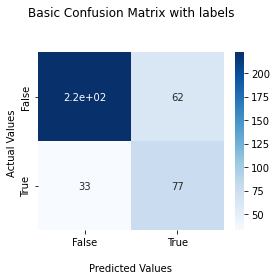

NameError: name 'classification_report' is not defined

In [19]:
# For Neighbour models
prediction_df = prediction_df_NBRS


# create confusion matrix for each of the product type
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
product = ['Basic', 'Deluxe', 'King', 'Standard', 'Super Deluxe' ]

for i in product:
    df = prediction_df[prediction_df[i].notnull()]
    
    y_test_basic = df[i]
    y_pred_basic = df[i + '_predclass']

    cf_matrix = confusion_matrix(y_test_basic, y_pred_basic) 
    
    fig, axes = plt.subplots(figsize=(4,4))

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=axes)
    
    ax.set_title(i+' Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    
    ## labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
 
    ## Display the visualization of the Confusion Matrix.
    plt.tight_layout()  
    plt.show()
    
    ## Performance metrics
    report_i = classification_report(y_test_basic, y_pred_basic)
    
    print(i + report_i)
    

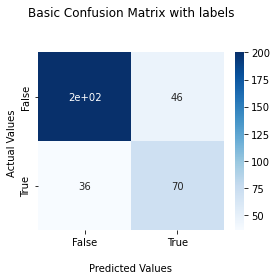

Basic              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       246
         1.0       0.60      0.66      0.63       106

    accuracy                           0.77       352
   macro avg       0.73      0.74      0.73       352
weighted avg       0.77      0.77      0.77       352



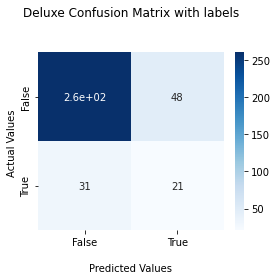

Deluxe              precision    recall  f1-score   support

         0.0       0.89      0.84      0.87       308
         1.0       0.30      0.40      0.35        52

    accuracy                           0.78       360
   macro avg       0.60      0.62      0.61       360
weighted avg       0.81      0.78      0.79       360



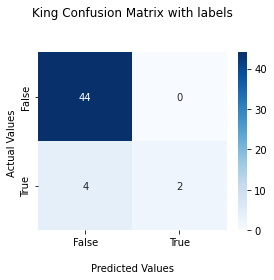

King              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        44
         1.0       1.00      0.33      0.50         6

    accuracy                           0.92        50
   macro avg       0.96      0.67      0.73        50
weighted avg       0.93      0.92      0.90        50



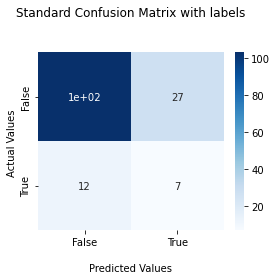

Standard              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84       130
         1.0       0.21      0.37      0.26        19

    accuracy                           0.74       149
   macro avg       0.55      0.58      0.55       149
weighted avg       0.81      0.74      0.77       149



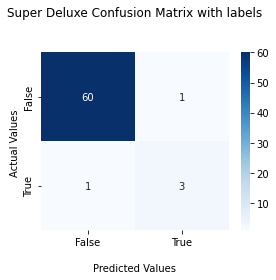

Super Deluxe              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        61
         1.0       0.75      0.75      0.75         4

    accuracy                           0.97        65
   macro avg       0.87      0.87      0.87        65
weighted avg       0.97      0.97      0.97        65



In [27]:
# For logistic models
prediction_df = prediction_df_MBRS


# create confusion matrix for each of the product type
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
product = ['Basic', 'Deluxe', 'King', 'Standard', 'Super Deluxe' ]

for i in product:
    df = prediction_df[prediction_df[i].notnull()]
    
    y_test_basic = df[i]
    y_pred_basic = df[i + '_predclass']

    cf_matrix = confusion_matrix(y_test_basic, y_pred_basic) 
      
    fig, axes = plt.subplots(figsize=(4,4))

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=axes)
    
    ax.set_title(i+' Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    
    ## labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
 
    ## Display the visualization of the Confusion Matrix.
    plt.tight_layout()  
    plt.show()
    
    ## Performance metrics
    report_i = classification_report(y_test_basic, y_pred_basic)
    
    print(i + report_i)
    

In [156]:
MBRS_accuracy = []
NBRS_accuracy = []

TN_all = 0
TP_all = 0
FN_all = 0
FP_all = 0

TN_all_2 = 0
TP_all_2 = 0
FN_all_2 = 0
FP_all_2 = 0
        
for _ in range(20):
    x = np.random.choice(df_test.index, size=500, replace=True)
    df_test_2 = pd.DataFrame(df_test, index=x)
    
    #actual_df = pd.DataFrame(df, index=x, columns = ['TARGET'])
    prediction_df_MBRS = MBRS_predict(df_test_2, numericColumn, itemColumns, MBRS_model)
    prediction_df_NBRS = NBRS_predict(df_test_2, numericColumn, itemColumns, NBRS_model)
    
    #actual_2.append(actual_df)
    #prediction_df_MBRS_2.append(prediction_df_MBRS)
    #prediction_df_NBRS_2.append(prediction_df_NBRS)
    
    # create confusion matrix for each of the product type
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_classification
    from sklearn.metrics import plot_confusion_matrix
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    product = ['Basic', 'Deluxe', 'King', 'Standard', 'Super Deluxe' ]

    for i in product:
        df = prediction_df_MBRS[prediction_df_MBRS[i].notnull()]

        y_test_basic = df[i]
        y_pred_basic = df[i + '_predclass']

        cf_matrix = confusion_matrix(y_test_basic, y_pred_basic) 
        
        TN = cf_matrix[0,0]
        TP = cf_matrix[1,1]
        FN = cf_matrix[1,0]
        FP = cf_matrix[0,1]
        
        TN_all = TN_all + TN
        TP_all = TP_all + TP
        FN_all = FN_all + FN
        FP_all = FP_all + FP
       
              
        df_2 = prediction_df_NBRS[prediction_df_NBRS[i].notnull()]

        y_test_basic = df_2[i]
        y_pred_basic = df_2[i + '_predclass']

        cf_matrix_2 = confusion_matrix(y_test_basic, y_pred_basic) 
        
        TN = cf_matrix_2[0,0]
        TP = cf_matrix_2[1,1]
        FN = cf_matrix_2[1,0]
        FP = cf_matrix_2[0,1]
        
        TN_all_2 = TN_all_2 + TN
        TP_all_2 = TP_all_2 + TP
        FN_all_2 = FN_all_2 + FN
        FP_all_2 = FP_all_2 + FP

        
    accuracy = (TP_all+TN_all)/(TP_all+TN_all+FN_all+FP_all)
    MBRS_accuracy.append(accuracy)

    accuracy = (TP_all_2+TN_all_2)/(TP_all_2+TN_all_2+FN_all_2+FP_all_2)
    NBRS_accuracy.append(accuracy)
                

 

In [157]:
print(NBRS_accuracy) 
print(MBRS_accuracy) 

[0.742, 0.761, 0.756, 0.752, 0.7496, 0.753, 0.7494285714285714, 0.75175, 0.7466666666666667, 0.7468, 0.748, 0.7485, 0.7503076923076923, 0.7524285714285714, 0.7550666666666667, 0.755375, 0.7545882352941177, 0.7552222222222222, 0.7554736842105263, 0.7558]
[0.774, 0.774, 0.7806666666666666, 0.782, 0.7808, 0.781, 0.78, 0.7815, 0.7773333333333333, 0.7752, 0.7745454545454545, 0.7743333333333333, 0.7736923076923077, 0.774, 0.7761333333333333, 0.776375, 0.7756470588235295, 0.775, 0.7773684210526316, 0.7782]


In [158]:
#idenpendent t-test - significant different 
from scipy import stats
stats.ttest_rel(NBRS_accuracy, MBRS_accuracy)

Ttest_relResult(statistic=-22.59111221794211, pvalue=3.4399987378351662e-15)

In [164]:
#one sample t-test using difference  - two-tail
diff = pd.DataFrame(MBRS_accuracy) - pd.DataFrame(NBRS_accuracy)
diff

t_statistic, p_value = stats.ttest_1samp(a=diff[0], popmean=0)
print(t_statistic , p_value)

22.59111221794211 3.4399987378351662e-15


In [169]:
#one sample t-test using difference  - one tail
from scipy import stats

t_value,p_value=stats.ttest_1samp(diff,0)

one_tailed_p_value=(p_value/2) # Since alternative hypothesis is one tailed, We need to divide the p value by 2.

print('Test statistic is %f'% (t_value))

print('p-value for one tailed test is %f'%one_tailed_p_value)


Test statistic is 22.591112
p-value for one tailed test is 0.000000


MBRS is significantly better than NBRS.